# **Perform inferCNV on given data**


In [ ]:
!pip install scanpy scipy umap-learn leidenalg scFates

In [ ]:
import scFates as scf
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

In [ ]:
!pip install infercnvpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
import scanpy as sc
import infercnvpy as cnv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/Computational Stem Cells/adata_used.h5ad'
adata = ad.read_h5ad(file_path)

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Create output directory for results
out_dir = "/content/drive/My Drive/Colab Notebooks/Computational Stem Cells/inferCNV_results"
os.makedirs(out_dir, exist_ok=True)

# Install R on Colab if not already installed
print("Installing R and dependencies...")
!apt-get update -qq
!apt-get install -y --no-install-recommends r-base r-base-dev libcurl4-openssl-dev libxml2-dev libssl-dev jags

# Install rpy2 if not already installed
!pip install rpy2

# Now import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

# Load the simulated data
print("Loading data ...")
adata_sim_visual = sc.read_h5ad('/content/drive/My Drive/Colab Notebooks/Computational Stem Cells/adata_used.h5ad')

# Setup R environment
print("Setting up R environment...")
# Initialize R
r = ro.r

# Install and load required R packages
print("Installing necessary R packages (this may take a while)...")
# Install BiocManager
r('if (!require("BiocManager", quietly = TRUE)) install.packages("BiocManager")')
# Install inferCNV
r('BiocManager::install("infercnv", dependencies=TRUE)')
# Load inferCNV
r('library(infercnv)')
print("R packages installed and loaded successfully")

# Prepare data for inferCNV
print("Preparing data for inferCNV...")


Installing R and dependencies...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcurl4-openssl-dev is already the newest version (7.81.0-1ubuntu1.20).
libssl-dev is already the newest version (3.0.2-0ubuntu1.19).
libxml2-dev is already the newest version (2.9.13+dfsg-1ubuntu0.7).
r-base-dev is already the newest version (4.5.0-3.2204.0).
r-base is already the newest version (4.5.0-3.2204.0).
The following NEW packages will be installed:
  jags
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 1,644 kB of archives.
After this operation, 3,492 kB of additional disk space will be used.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ jags 4.3.2-1.2204.0 [1,644 kB]
Fetched 1,644 kB in 0s (7,954 kB/s)
Selecting p

In [ ]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

# Create output directory (with NO spaces in the path)
out_dir = "/content/drive/My Drive/Colab Notebooks/Computational Stem Cells/inferCNV_out"  # Simple path with no spaces
os.makedirs(out_dir, exist_ok=True)

# Load the data
print("Loading simulated CNV data...")
adata_sim_visual = sc.read_h5ad('/content/drive/My Drive/Colab Notebooks/Computational Stem Cells/adata_used.h5ad')

# Subsample for faster processing
n_cells = 2000
print(f"Subsampling to {n_cells} cells...")
np.random.seed(42)  # For reproducibility
cell_indices = np.random.choice(adata_sim_visual.obs_names, size=n_cells, replace=False)
adata_subset = adata_sim_visual[cell_indices].copy()

# Export count matrix
print("Exporting count matrix...")
if 'counts' in adata_subset.layers:
    counts = pd.DataFrame(
        adata_subset.layers['counts'].toarray()
        if hasattr(adata_subset.layers['counts'], 'toarray')
        else adata_subset.layers['counts'],
        index=adata_subset.obs_names,
        columns=adata_subset.var_names
    )
else:
    counts = pd.DataFrame(
        adata_subset.X.toarray()
        if hasattr(adata_subset.X, 'toarray')
        else adata_subset.X,
        index=adata_subset.obs_names,
        columns=adata_subset.var_names
    )

counts_file = os.path.join(out_dir, "counts.txt")
counts.to_csv(counts_file, sep='\t')

# Export cell annotations
print("Exporting cell annotations...")
annotations = pd.DataFrame(index=adata_subset.obs_names)
annotations['cell_type'] = adata_subset.obs['simulated_cnvs']
annotations_file = os.path.join(out_dir, "annotations.txt")
annotations.to_csv(annotations_file, sep='\t', header=False)

# Export gene positions
print("Exporting gene positions...")
gene_order = adata_subset.var[['chromosome', 'start', 'end']].copy()
gene_order.index.name = 'gene_name'
gene_order.reset_index(inplace=True)
gene_order_file = os.path.join(out_dir, "gene_order.txt")
gene_order.to_csv(gene_order_file, sep='\t', index=False)

# Create R script that references local files directly
r_script = """
library(infercnv)

# Create the inferCNV object
infercnv_obj <- CreateInfercnvObject(
    raw_counts_matrix="counts.txt",
    annotations_file="annotations.txt",
    gene_order_file="gene_order.txt",
    ref_group_names="normal"
)

# Run inferCNV
infercnv_obj <- run(
    infercnv_obj,
    cutoff=0.1,
    out_dir="./",
    cluster_by_groups=TRUE,
    denoise=TRUE,
    HMM=FALSE,
    analysis_mode="samples",
    num_threads=2,
    no_plot=FALSE
)

# Save the inferCNV object
saveRDS(infercnv_obj, file="infercnv_obj.rds")

print("inferCNV analysis completed successfully")
"""

r_script_path = os.path.join(out_dir, "run_infercnv.R")
with open(r_script_path, 'w') as f:
    f.write(r_script)

# Create a proper shell script with quoted paths
shell_script = """#!/bin/bash
cd "{0}"
Rscript run_infercnv.R
""".format(out_dir)

shell_script_path = os.path.join(out_dir, "run.sh")
with open(shell_script_path, 'w') as f:
    f.write(shell_script)

# Make executable
!chmod +x "{shell_script_path}"

# Run the analysis from the current directory
print("Executing inferCNV analysis...")
!cd "{out_dir}" && Rscript run_infercnv.R

# Print summary of results
print("\nCNA Analysis Summary:")
print(f"Data processed: {n_cells} cells")
print(f"Results saved to: {out_dir}")

# Check what files were created
!ls -la "{out_dir}"

print("Analysis complete")

Loading simulated CNV data...
Subsampling to 2000 cells...
Exporting count matrix...
Exporting cell annotations...
Exporting gene positions...
Executing inferCNV analysis...
INFO [2025-05-06 20:11:15] Parsing matrix: counts.txt
INFO [2025-05-06 20:11:52] Parsing gene order file: gene_order.txt
INFO [2025-05-06 20:11:52] Parsing cell annotations file: annotations.txt
Error in CreateInfercnvObject(raw_counts_matrix = "counts.txt", annotations_file = "annotations.txt",  : 
  Please make sure that all the annotated cell  names match a sample in your data matrix.  Attention to:  TTTCATGGTAGCTAAA-1,GCCAGGTCAGGTCTCG-1,AAGCCATTCCATTGTT-1,TGATGCAGTCTTCAAG-1,TCGCACTGTTGATGTC-1,AAAGGATAGTGAATAC-1,CTCATTAAGCTTTCTT-1,TCGTCCACAGTCGGTC-1,AAGAACAAGTCTCCTC-1,ACATTTCTCAAAGAAC-1,ACATGCAGTACCCGAC-1,CCGGTAGTCACGACTA-1,TAACTTCAGCGACTGA-1,ACACAGTCATGGATCT-1,CAGTTCCAGCGTCGAA-1,ATTCAGGTCGTTACCC-1,AAAGAACGTCTCGGGT-1,TGATCAGCAGTAACCT-1,ACTTCGCGTAGAGCTG-1,TCGCTTGCACCAGGTC-1,CCACTTGTCTTAGCCC-1,GGAGAACCAAAGAGTT-1,G

Loading the simulated CNV data...
Found 6312 normal cells and 3997 cells with CNAs
Processing expression data...
Filtered to 24 standard chromosomes: ['1', '2', '3', '4', '5', '6', '7', 'X', '8', '9', '11', '10', '12', '13', '14', '15', '16', '17', '18', '20', '19', 'Y', '22', '21']
Creating CNA heatmap...
Creating chromosome-level summary...


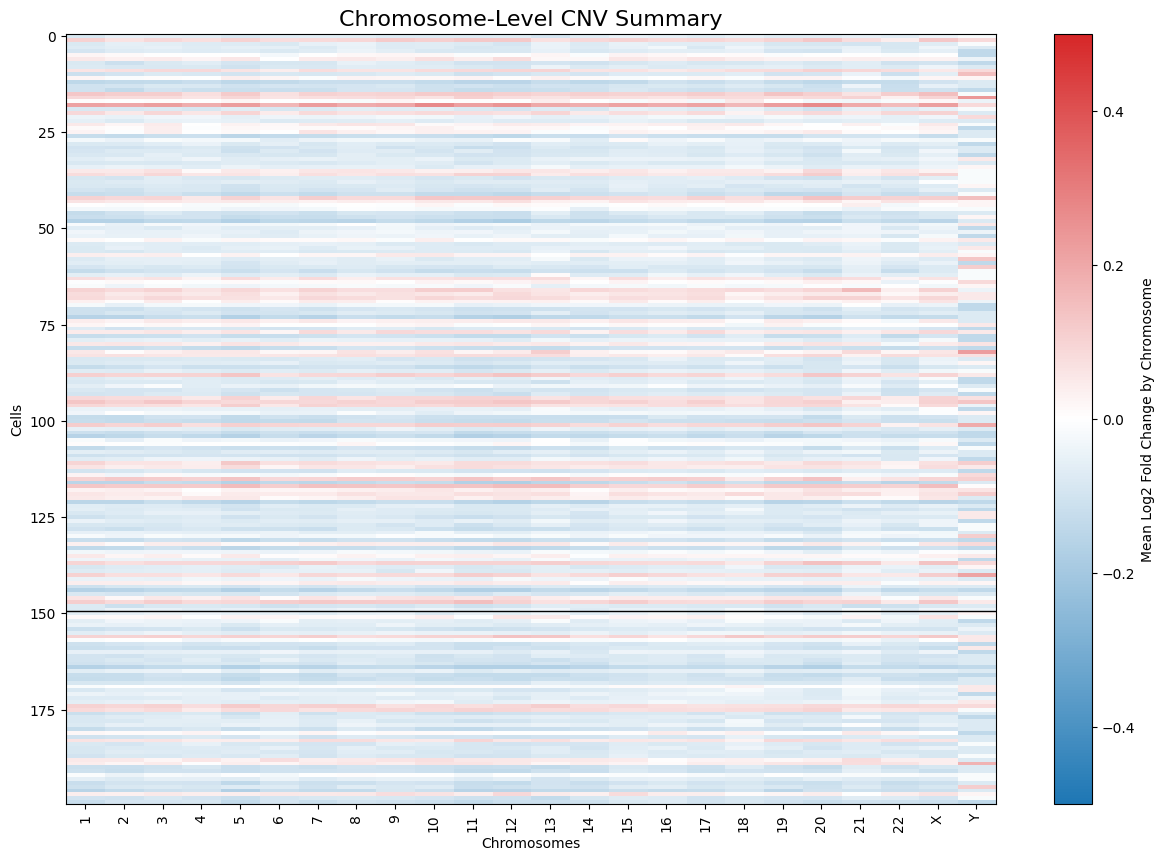

Visualizations saved to /content/drive/My Drive/Colab Notebooks/Computational Stem Cells/inferCNV_viz


In [ ]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import re

# Set output paths
viz_dir = "/content/drive/My Drive/Colab Notebooks/Computational Stem Cells/inferCNV_viz"
os.makedirs(viz_dir, exist_ok=True)

# Load your data
print("Loading the simulated CNV data...")
adata_sim_visual = sc.read_h5ad('/content/drive/My Drive/Colab Notebooks/Computational Stem Cells/adata_used.h5ad')

# Identify normal and CNA cells
is_normal = adata_sim_visual.obs['simulated_cnvs'] == ''
normal_cells = adata_sim_visual.obs_names[is_normal]
cna_cells = adata_sim_visual.obs_names[~is_normal]
print(f"Found {len(normal_cells)} normal cells and {len(cna_cells)} cells with CNAs")

# Extract expression data
print("Processing expression data...")
if 'counts' in adata_sim_visual.layers:
    expr = (
        adata_sim_visual.layers['counts'].toarray()
        if hasattr(adata_sim_visual.layers['counts'], 'toarray')
        else adata_sim_visual.layers['counts']
    )
else:
    expr = (
        adata_sim_visual.X.toarray()
        if hasattr(adata_sim_visual.X, 'toarray')
        else adata_sim_visual.X
    )

# Create DataFrame with cell names as index
expr_df = pd.DataFrame(
    expr,
    index=adata_sim_visual.obs_names,
    columns=adata_sim_visual.var_names
)

# Calculate mean of normal cells
normal_mean = expr_df.loc[normal_cells].mean()

# Calculate log2 fold change (add 1 to avoid log(0))
log_fc = np.log2((expr_df + 1) / (normal_mean + 1))

# Filter for standard chromosomes (1-22, X, Y) only
standard_chroms = []
for chrom in adata_sim_visual.var['chromosome'].unique():
    if pd.notna(chrom):
        chrom_str = str(chrom)
        # Match chromosomes 1-22, X, Y with or without 'chr' prefix
        if re.match(r'^(chr)?([1-9]|1[0-9]|2[0-2]|X|Y)$', chrom_str, re.IGNORECASE):
            standard_chroms.append(chrom)

print(f"Filtered to {len(standard_chroms)} standard chromosomes: {standard_chroms}")

# Create chromosome ordering
def chrom_order(x):
    x = str(x).upper().replace('CHR', '')
    if x.isdigit():
        return int(x)
    elif x == 'X':
        return 23
    elif x == 'Y':
        return 24
    else:
        return 100

# Sort standard chromosomes naturally
chromosomes = sorted(standard_chroms, key=chrom_order)

# Create ordered gene list
ordered_genes = []
chr_boundaries = []
chr_labels = []
current_pos = 0

for chrom in chromosomes:
    # Get genes for this chromosome in position order
    chr_mask = adata_sim_visual.var['chromosome'] == chrom
    if chr_mask.sum() > 0:
        chr_genes = adata_sim_visual.var[chr_mask].sort_values('start').index.tolist()

        # Record chromosome boundary
        chr_boundaries.append(current_pos)
        chr_labels.append((current_pos + len(chr_genes)//2, str(chrom).replace('chr', '')))

        # Add genes to ordered list
        ordered_genes.extend(chr_genes)
        current_pos += len(chr_genes)

# Create visualization 1: Heatmap of CNAs
print("Creating CNA heatmap...")
# Sample cells for visualization
max_cna_cells = min(150, len(cna_cells))
max_normal_cells = min(50, len(normal_cells))

sampled_cna = np.random.choice(cna_cells, max_cna_cells, replace=False)
sampled_normal = np.random.choice(normal_cells, max_normal_cells, replace=False)
cells_to_plot = np.concatenate([sampled_cna, sampled_normal])

# Clip extreme values for visualization
log_fc_capped = log_fc.clip(-1.5, 1.5)

# Create figure
plt.figure(figsize=(20, 12))
heatmap_data = log_fc_capped.loc[cells_to_plot, ordered_genes]

# Create custom colormap (blue=deletions, red=amplifications)
cmap = LinearSegmentedColormap.from_list(
    'custom_diverging',
    ['#1e77b4', '#ffffff', '#d62728'],  # blue, white, red
    N=256
)

# Plot heatmap
im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add chromosome boundaries
for boundary in chr_boundaries[1:]:  # Skip the first boundary at 0
    plt.axvline(x=boundary, color='black', linestyle='-', linewidth=0.5)

# Add chromosome labels
for pos, label in chr_labels:
    plt.text(pos, -5, label, ha='center', fontsize=10, weight='bold')

# Add separation line between CNA and normal cells
plt.axhline(y=max_cna_cells - 0.5, color='black', linestyle='-', linewidth=1)

# Add labels for cell types
plt.text(len(ordered_genes) + 5, max_cna_cells/2, 'Cells with CNAs',
         rotation=270, va='center', fontsize=12)
plt.text(len(ordered_genes) + 5, max_cna_cells + max_normal_cells/2, 'Normal Cells',
         rotation=270, va='center', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, orientation='vertical', pad=0.01)
cbar.set_label('Log2 Fold Change vs Normal Cells')

# Add title and labels
plt.title('Copy Number Variation Heatmap (Simulated CNVs)', fontsize=16)
plt.xlabel('Genes (ordered by chromosomal position)')
plt.ylabel('Cells')

# Remove x-ticks (too many genes)
plt.xticks([])

# Save figure
heatmap_file = os.path.join(viz_dir, 'cnv_heatmap.png')
plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
plt.close()

# Create visualization 2: Chromosome-level summary
print("Creating chromosome-level summary...")
chrom_data = pd.DataFrame(index=log_fc.index)

for chrom in chromosomes:
    # Get genes for this chromosome
    chr_genes = adata_sim_visual.var[adata_sim_visual.var['chromosome'] == chrom].index
    if len(chr_genes) > 0:
        # Calculate mean log FC by chromosome
        chrom_data[chrom] = log_fc[chr_genes].mean(axis=1)

# Create the heatmap
plt.figure(figsize=(15, 10))
chrom_data_capped = chrom_data.clip(-0.8, 0.8)
chrom_plot = chrom_data_capped.loc[cells_to_plot]

# Plot heatmap
im = plt.imshow(chrom_plot, cmap=cmap, aspect='auto', vmin=-0.5, vmax=0.5)

# Add a line to separate CNA and normal cells
plt.axhline(y=max_cna_cells - 0.5, color='black', linestyle='-', linewidth=1.0)

# Format chromosome labels - remove 'chr' prefix for cleaner display
chrom_labels = [str(c).replace('chr', '') for c in chrom_data.columns]

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Mean Log2 Fold Change by Chromosome')

# Add labels
plt.title('Chromosome-Level CNV Summary', fontsize=16)
plt.ylabel('Cells')
plt.xlabel('Chromosomes')
plt.xticks(range(len(chrom_labels)), chrom_labels, rotation=90)

# Save the visualization
summary_file = os.path.join(viz_dir, 'chromosome_summary.png')
plt.savefig(summary_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualizations saved to {viz_dir}")